## Selecting the Best Model.
### Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path

# Detect project root (parent of notebooks/)
ROOT = Path.cwd().parents[0]

# Add root to path if not present
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Define paths used in the pipeline
DATA_TRAIN   = ROOT / "data" / "interim" / "training_fe.csv"
DATA_LABELS  = ROOT / "data" / "raw" / "training_set_labels.csv"

ARTIFACTS    = ROOT / "artifacts"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
# Import utility functions from src
from src.modeling import load_training_data, compute_metrics, save_confusion_matrices, TARGET_COLS
# ARTIFACTS = ROOT / "artifacts"
ARTIFACTS_COMPARISON = ARTIFACTS / "model_comparison"
ARTIFACTS_COMPARISON.mkdir(parents=True, exist_ok=True)
print(f"Artifacts will be saved to: {ARTIFACTS_COMPARISON}")

Artifacts will be saved to: c:\Projects\Flushot\artifacts\model_comparison


### Load and Split Data

In [3]:
# Load data
print("Loading data...")
X, y = load_training_data(str(DATA_TRAIN), str(DATA_LABELS))
# Split into train and validation sets (80% train, 20% validation)
# We use a fixed random state for reproducibility
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Loading data...
Training shape: (21365, 72)
Validation shape: (5342, 72)


### Define Models

In [4]:
# Define the models to compare
models_config = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
}

### Train, Evaluate, and Collect Metrics

In [5]:
# Initialize storage for results
comparison_results = []
print("Starting model comparison...")
for target in TARGET_COLS:
    print(f"\n=== Target: {target} ===")
    y_train_target = y_train[target]
    y_val_target = y_val[target]
    
    for model_name, model in models_config.items():
        print(f"Training {model_name}...")
        
        # Train model
        model.fit(X_train, y_train_target)
        
        # Predict
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]
        
        # Compute metrics
        metrics = compute_metrics(y_val_target, y_pred, y_prob)
        
        # Add to results
        result_entry = {
            "Target": target,
            "Model": model_name,
            **metrics
        }
        comparison_results.append(result_entry)
        
        # Save confusion matrices
        # Filename safe model name
        safe_model_name = model_name.replace(" ", "_").lower()
        save_confusion_matrices(
            y_val_target, 
            y_pred, 
            f"{target}_{safe_model_name}", 
            str(ARTIFACTS_COMPARISON)
        )
        
        print(f"  {model_name} ROC-AUC: {metrics['roc_auc']:.4f}")
print("\nComparison complete.")

Starting model comparison...

=== Target: h1n1_vaccine ===
Training Logistic Regression...
  Logistic Regression ROC-AUC: 0.8622
Training Random Forest...
  Random Forest ROC-AUC: 0.8645
Training LightGBM...
  LightGBM ROC-AUC: 0.8705

=== Target: seasonal_vaccine ===
Training Logistic Regression...
  Logistic Regression ROC-AUC: 0.8564
Training Random Forest...
  Random Forest ROC-AUC: 0.8562
Training LightGBM...
  LightGBM ROC-AUC: 0.8636

Comparison complete.


### Create Comparison Table

In [6]:
# Create DataFrame from results
df_results = pd.DataFrame(comparison_results)
# Display the table
print("\n=== Model Comparison Table ===")
display(df_results)
# Save table to CSV
df_results.to_csv(ARTIFACTS_COMPARISON / "model_comparison_metrics.csv", index=False)


=== Model Comparison Table ===


,Target,Model,accuracy,precision,recall,f1,roc_auc
0,h1n1_vaccine,Logistic Regression,0.853613,0.730159,0.488496,0.585366,0.862170
1,h1n1_vaccine,Random Forest,0.848559,0.740630,0.437168,0.549805,0.864452
2,h1n1_vaccine,LightGBM,0.854549,0.719255,0.512389,0.598450,0.870486
3,seasonal_vaccine,Logistic Regression,0.789030,0.779561,0.753162,0.766134,0.856361
4,seasonal_vaccine,Random Forest,0.779671,0.768324,0.744186,0.756062,0.856206
5,seasonal_vaccine,LightGBM,0.787346,0.772031,0.761322,0.766639,0.863632


### Select Best Model

In [7]:
# Identify best model for each target based on ROC-AUC
print("\n=== Best Models (based on ROC-AUC) ===")
best_models_summary = df_results.loc[df_results.groupby("Target")["roc_auc"].idxmax()]
display(best_models_summary[["Target", "Model", "roc_auc", "f1", "precision", "recall"]])
for _, row in best_models_summary.iterrows():
    print(f"Best model for {row['Target']}: {row['Model']} (ROC-AUC: {row['roc_auc']:.4f})")


=== Best Models (based on ROC-AUC) ===


,Target,Model,roc_auc,f1,precision,recall
2,h1n1_vaccine,LightGBM,0.870486,0.598450,0.719255,0.512389
5,seasonal_vaccine,LightGBM,0.863632,0.766639,0.772031,0.761322


Best model for h1n1_vaccine: LightGBM (ROC-AUC: 0.8705)
Best model for seasonal_vaccine: LightGBM (ROC-AUC: 0.8636)


### Candidate Models & Performance
We evaluated three distinct architectures to identify the optimal model:
*   **Logistic Regression**: Linear baseline.
*   **Random Forest**: Non-linear bagging ensemble.
*   **LightGBM**: Gradient boosting framework.

**Result**: LightGBM outperformed baselines on the validation set for both targets using the **ROC-AUC** metric.

| Target | Model | ROC-AUC | Lift vs LogReg |
| :--- | :--- | :--- | :--- |
| **H1N1 Vaccine** | **LightGBM** | **0.8705** | +0.83% |
| **Seasonal Flu** | **LightGBM** | **0.8636** | +0.72% |

### Why ROC-AUC & LightGBM?

#### The Challenge: Imbalance
*   **H1N1** is effectively imbalanced (**21%** positive / 79% negative).
*   **Seasonal Flu** is balanced (**47%** positive / 53% negative).
*   *Selection Metric*: **ROC-AUC** was chosen over Accuracy/F1 because it is threshold-independent and robust to imbalance, ensuring the model prioritizes ranking actual positive cases higher rather than just maximizing majority class accuracy.

#### The Solution: LightGBM
*   **Boosting Mechanism**: By training sequentially on residuals, LightGBM naturally focuses learning on "hard" examples (often the minority positive class in H1N1), improving discrimination where others fail.
*   **Interpretability (SHAP)**: LightGBM supports **TreeSHAP**, enabling the computation of *exact* feature contributions (Shapley values). This is critical for explaining *why* specific demographics are predicted as high-affinity for the vaccine, ensuring actionable and trustworthy insights.

Processing h1n1_vaccine...


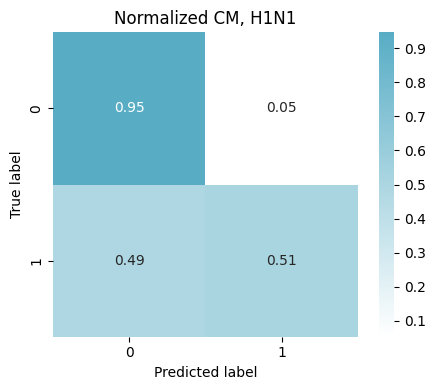

Saved normalized confusion matrix to: c:\Projects\Flushot\artifacts\model_comparison\h1n1_lgbm_norm_updated.png
Processing seasonal_vaccine...


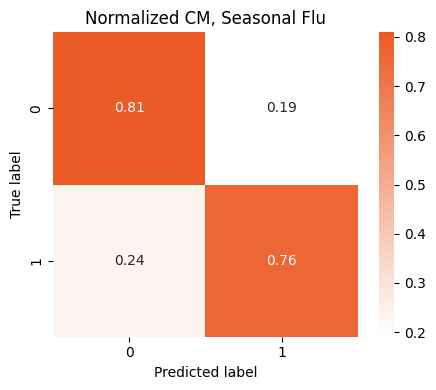

Saved normalized confusion matrix to: c:\Projects\Flushot\artifacts\model_comparison\seasonal_lgbm_norm_updated.png


In [ ]:
# Adjust the confusion matrix color palette and titles

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier

# Define the custom configuration for the plots
cm_config = {
    "h1n1_vaccine": {
        "color": "#58ADC5",
        "title": "Normalized CM, H1N1",
        "filename": "h1n1_lgbm_norm_updated.png"
    },
    "seasonal_vaccine": {
        "color": "#EA5B25",
        "title": "Normalized CM, Seasonal Flu",
        "filename": "seasonal_lgbm_norm_updated.png"
    }
}

# Ensure the output directory exists
# ARTIFACTS_COMPARISON is defined in the notebook setup
ARTIFACTS_COMPARISON.mkdir(parents=True, exist_ok=True)

# Loop through each target to train the best model (LightGBM) and generate the plot
for target in TARGET_COLS:
    print(f"Processing {target}...")
    
    # 1. Select the specific target data
    y_train_curr = y_train[target]
    y_val_curr = y_val[target]
    
    # 2. Retrain the LightGBM model (Best Model)
    # Re-initializing to ensure a fresh fit for each target
    # Using parameters consistent with the notebook's LightGBM configuration
    model = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
    model.fit(X_train, y_train_curr)
    
    # 3. Predict on validation set
    y_pred = model.predict(X_val)
    
    # 4. Compute Normalized Confusion Matrix
    # normalize='true' normalizes over the true labels (rows)
    cm_norm = confusion_matrix(y_val_curr, y_pred, normalize='true')
    
    # 5. Create Custom Colormap (White -> Target Color)
    target_config = cm_config[target]
    custom_cmap = LinearSegmentedColormap.from_list(
        f"cmap_{target}", ["#ffffff", target_config["color"]]
    )
    
    # 6. Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm_norm, 
        annot=True, 
        fmt=".2f", 
        cmap=custom_cmap, 
        cbar=True,
        square=True
    )
    
    plt.title(target_config["title"], fontsize=12)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    # 7. Save
    save_path = ARTIFACTS_COMPARISON / target_config["filename"]
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Saved normalized confusion matrix to: {save_path}")